In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

class OPTICS:
    def __init__(self, min_samples=5, max_eps=float('inf')):
        self.min_samples = min_samples
        self.max_eps = max_eps
        self.reachability_ = None
        self.ordering_ = None
        self.core_distances_ = None
        self.labels_ = None

    def fit(self, X):
        n_points = X.shape[0]
        self.reachability_ = np.full(n_points, float('inf'))
        self.ordering_ = np.zeros(n_points, dtype=int)
        self.core_distances_ = np.full(n_points, float('inf'))
        self.labels_ = np.full(n_points, -1)

        processed = np.zeros(n_points, dtype=bool)
        index_order = 0

        for point_idx in range(n_points):
            if processed[point_idx]:
                continue

            neighbors = self._get_neighbors(X, point_idx)
            processed[point_idx] = True
            self.ordering_[index_order] = point_idx
            index_order += 1

            if len(neighbors) >= self.min_samples:
                core_dist = self._core_distance(X, point_idx, neighbors)
                self.core_distances_[point_idx] = core_dist
                self._update(X, neighbors, point_idx, processed, core_dist, index_order)
            else:
                self.core_distances_[point_idx] = float('inf')

        self._extract_clusters()

    def _get_neighbors(self, X, point_idx):
        distances = pairwise_distances(X[point_idx].reshape(1, -1), X)[0]
        neighbors = np.where(distances <= self.max_eps)[0]
        return neighbors

    def _core_distance(self, X, point_idx, neighbors):
        distances = pairwise_distances(X[point_idx].reshape(1, -1), X[neighbors])[0]
        sorted_distances = np.sort(distances)
        core_distance = sorted_distances[self.min_samples - 1] if len(neighbors) >= self.min_samples else float('inf')
        return core_distance

    def _update(self, X, neighbors, point_idx, processed, core_dist, index_order):
        seeds = {}
        for neighbor_idx in neighbors:
            if processed[neighbor_idx]:
                continue

            new_reachability = max(core_dist, np.linalg.norm(X[point_idx] - X[neighbor_idx]))
            if self.reachability_[neighbor_idx] == float('inf'):
                self.reachability_[neighbor_idx] = new_reachability
                seeds[neighbor_idx] = new_reachability
            elif new_reachability < self.reachability_[neighbor_idx]:
                self.reachability_[neighbor_idx] = new_reachability
                seeds[neighbor_idx] = new_reachability

        while seeds:
            next_point_idx = min(seeds, key=seeds.get)
            del seeds[next_point_idx]
            processed[next_point_idx] = True
            self.ordering_[index_order] = next_point_idx
            index_order += 1

            neighbors = self._get_neighbors(X, next_point_idx)
            if len(neighbors) >= self.min_samples:
                core_dist = self._core_distance(X, next_point_idx, neighbors)
                self.core_distances_[next_point_idx] = core_dist
                self._update(X, neighbors, next_point_idx, processed, core_dist, index_order)

    def _extract_clusters(self):
        cluster_id = 0
        for i in range(len(self.ordering_)):
            if self.core_distances_[self.ordering_[i]] != float('inf'):
                self.labels_[self.ordering_[i]] = cluster_id
                if i < len(self.ordering_) - 1 and self.reachability_[self.ordering_[i+1]] > self.core_distances_[self.ordering_[i]]:
                    cluster_id += 1

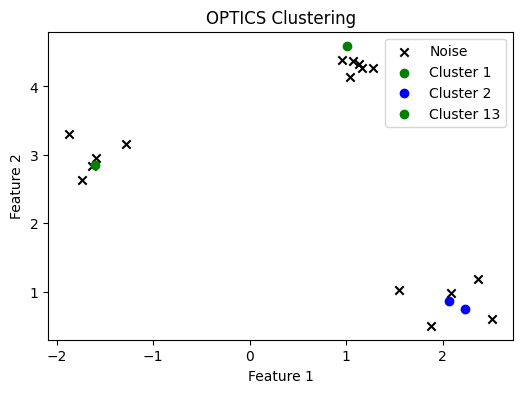

In [13]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate random data points
X, _ = make_blobs(n_samples=20, centers=3, cluster_std=0.2, random_state=0)

# Assume we have an optics instance that has already been fit
optics = OPTICS(min_samples=5, max_eps=0.5)
optics.fit(X)

# Define a list of colors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plotting the results
plt.figure(figsize=(6, 4))
unique_labels = np.unique(optics.labels_)

for cluster_id in unique_labels:
    if cluster_id == -1:
        # Noise points (usually colored black)
        plt.scatter(X[optics.labels_ == cluster_id, 0], X[optics.labels_ == cluster_id, 1], c='k', marker='x', label='Noise')
    else:
        # Assign colors to clusters
        color = colors[cluster_id % len(colors)]
        plt.scatter(X[optics.labels_ == cluster_id, 0], X[optics.labels_ == cluster_id, 1], c=color, marker='o', label=f'Cluster {cluster_id}')

plt.title('OPTICS Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()